In [8]:
!pip install comet_ml

In [55]:
from comet_ml import Experiment
from comet_ml import ExistingExperiment

import IPython.display as ipd

import numpy as np

import pandas as pd

import librosa
from librosa import display  

import matplotlib.pyplot as plt

from scipy.io import wavfile as wav

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical

import os

In [57]:
experiment = Experiment(api_key="IhQTOG01VFubRZ3TqW8IaWsKk", project_name="music-maker-ai", workspace="temasarkisov")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/temasarkisov/music-maker-ai/471eca98cb2845a0955c8aa45effda10



In [11]:
!wget https://goo.gl/8hY5ER

--2020-08-25 12:28:32--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 74.125.195.100, 74.125.195.102, 74.125.195.113, ...
Connecting to goo.gl (goo.gl)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2020-08-25 12:28:32--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘8hY5ER’

8hY5ER              100%[===================>]   5.61G  14.5MB/s    in 9m 33s  

2020-08-25 12:38:07 (10.0 MB/s) - ‘8hY5ER’ saved [6023741708/6023741708]



In [ ]:
!tar -zxvf 8hY5ER
!rm -f 8hY5ER

In [47]:
df = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv') 
labels = list(df['class'].unique())

In [58]:
print(df.shape)
df.head(5)

(8732, 8)


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [59]:
files = dict()
for i in range(len(labels)):
    tmp = df[df['class'] == labels[i]][:1].reset_index()
    path = 'UrbanSound8K/audio/fold{}/{}'.format(tmp['fold'][0], tmp['slice_file_name'][0])
    files[labels[i]] = path

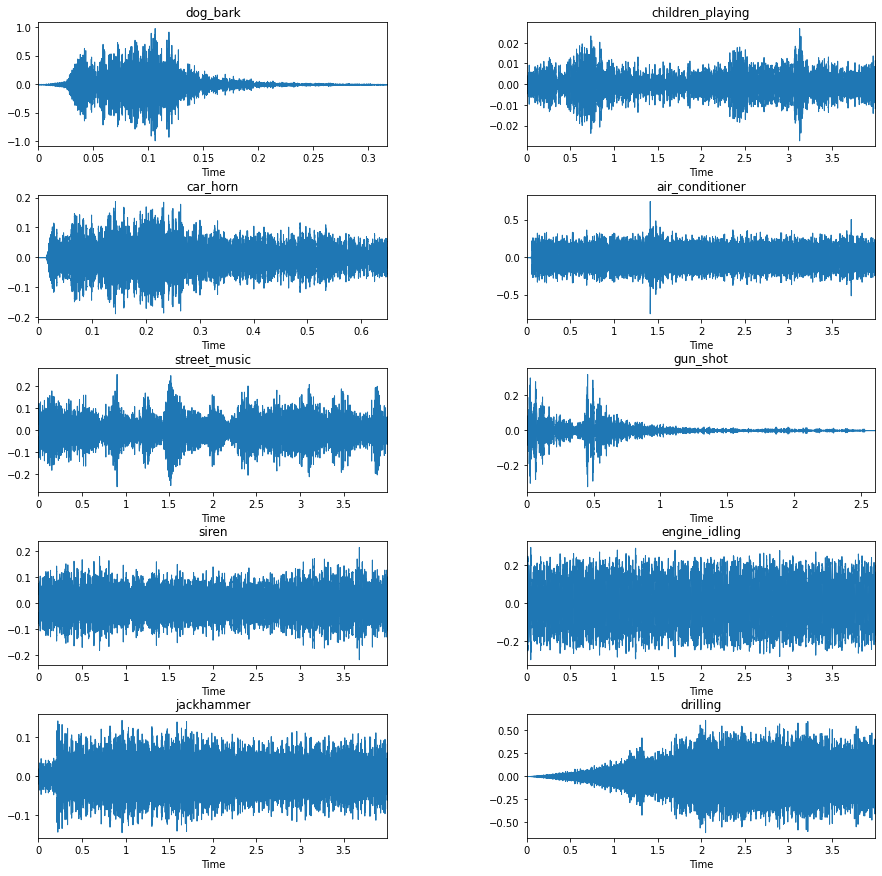

In [60]:
fig = plt.figure(figsize=(15,15)) # Log graphic of waveforms to Comet
experiment.log_image('class_examples.png')
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr= sample_rate)
plt.savefig('class_examples.png')


In [61]:
# Log graphic of waveforms to Comet
experiment.log_image('class_examples.png')

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=c038078c1d124367bf6be98cd614459e&experimentKey=471eca98cb2845a0955c8aa45effda10',
 'imageId': 'c038078c1d124367bf6be98cd614459e',
 'web': 'https://www.comet.ml/api/image/download?imageId=c038078c1d124367bf6be98cd614459e&experimentKey=471eca98cb2845a0955c8aa45effda10'}

In [62]:
# Log audio files to Comet for debugging
for label in labels:
    fn = files[label]
    experiment.log_audio(fn, metadata = {'name': label})

In [63]:
fn = 'UrbanSound8K/audio/fold1/191431-9-0-66.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 48000
Librosa sample rate: 22050


In [64]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -1869 to 1665
Librosa audio file min~max range: -0.05 to -0.05


{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=5b254f82d58b470cb3453d4cf6ce2dc3&experimentKey=471eca98cb2845a0955c8aa45effda10',
 'imageId': '5b254f82d58b470cb3453d4cf6ce2dc3',
 'web': 'https://www.comet.ml/api/image/download?imageId=5b254f82d58b470cb3453d4cf6ce2dc3&experimentKey=471eca98cb2845a0955c8aa45effda10'}

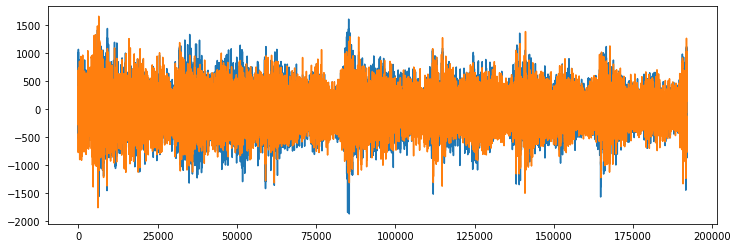

In [65]:
# Original Audio (note that it’s in stereo — two audio sources)
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')
experiment.log_image('original_audio.png')

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=ee03dd5f92484b1d907237c316eb06d6&experimentKey=471eca98cb2845a0955c8aa45effda10',
 'imageId': 'ee03dd5f92484b1d907237c316eb06d6',
 'web': 'https://www.comet.ml/api/image/download?imageId=ee03dd5f92484b1d907237c316eb06d6&experimentKey=471eca98cb2845a0955c8aa45effda10'}

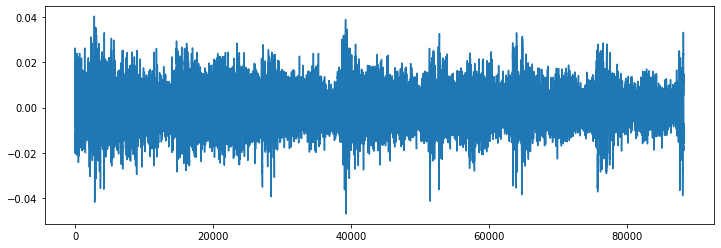

In [66]:
# Librosa: mono track
# Librosa audio: converted to mono
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')
experiment.log_image('librosa_audio.png')

In [67]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)

In [68]:
print(mfccs.shape)

(40, 173)


{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=584fb6b718b4492bb49981f5096ce8b3&experimentKey=471eca98cb2845a0955c8aa45effda10',
 'imageId': '584fb6b718b4492bb49981f5096ce8b3',
 'web': 'https://www.comet.ml/api/image/download?imageId=584fb6b718b4492bb49981f5096ce8b3&experimentKey=471eca98cb2845a0955c8aa45effda10'}

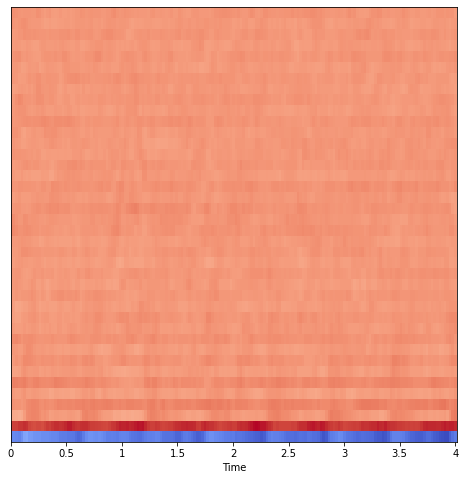

In [69]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')
experiment.log_image('MFCCs.png')

In [70]:
# Define a simple function to extract MFCCs for every file in our dataset
def extract_features(file_name):
  audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
  mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_processed = np.mean(mfccs.T,axis=0)
     
  return mfccs_processed

In [ ]:
# Now let’s extract features
features = []
# Iterate through each sound file and extract the features 
for index, row in df.iterrows():
  file_name = os.path.join(os.path.abspath('/content/UrbanSound8K/audio'),'fold'+str(row["fold"])+'/', str(row["slice_file_name"]))  
  class_label = row["class"]
  data = extract_features(file_name)
    
  features.append([data, class_label])
  print(index)

# Convert into a Pandas dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

In [72]:
# Now that we have successfully extracted our features from the underlying audio data, we can build and train a model
featuresdf.iloc[0]['feature']

array([-2.15793002e+02,  7.16661219e+01, -1.31813771e+02, -5.20913311e+01,
       -2.21159665e+01, -2.17641820e+01, -1.11837471e+01,  1.89126802e+01,
        6.72663857e+00,  1.45568942e+01, -1.17820459e+01,  2.30103687e+00,
       -1.72513042e+01,  1.00524210e+01, -6.00949902e+00, -1.31531933e+00,
       -1.76935098e+01,  1.11712237e+00, -4.36994472e+00,  7.26295284e+00,
       -1.18159701e+01, -7.49526155e+00,  5.45771322e+00, -2.94424547e+00,
       -5.86938886e+00, -9.86548550e-02, -3.21217006e+00,  4.60925117e+00,
       -5.82932691e+00, -5.34750733e+00,  1.33412192e+00,  7.13078249e+00,
       -7.94496715e-02,  1.71092448e+00, -5.69420010e+00, -2.90417137e+00,
        3.03669585e+00, -1.68275889e+00, -8.85858221e-01,  3.54388936e-01])

In [73]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [74]:
# Split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [75]:
num_labels = yy.shape[1]
filter_size = 2

def build_model_graph(input_shape=(40,)):
  model = Sequential()
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_labels))
  model.add(Activation('softmax'))
  
  # Compile the model
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
  return model

In [78]:
model = build_model_graph()

In [79]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/100
219/219 [==============================] - 1s 4ms/step - loss: 8.5603 - accuracy: 0.1781 - val_loss: 2.1725 - val_accuracy: 0.2232
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 2.2771 - accuracy: 0.2316 - val_loss: 2.0535 - val_accuracy: 0.2479
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 2.0450 - accuracy: 0.2832 - val_loss: 1.8633 - val_accuracy: 0.3566
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 1.8896 - accuracy: 0.3257 - val_loss: 1.7059 - val_accuracy: 0.3955
Epoch 5/100
219/219 [==============================] - 1s 3ms/step - loss: 1.7933 - accuracy: 0.3596 - val_loss: 1.6188 - val_accuracy: 0.4556
Epoch 6/100
219/219 [==============================] - 1s 3ms/step - loss: 1.7270 - accuracy: 0.3898 - val_loss: 1.5446 - val_accuracy: 0.4705
Epoch 7/100
219/219 [==============================] - 1s 4ms/step - loss: 1.6239 - accuracy: 0.4238 - val_loss: 1.4490 - val_accuracy: 0.5197

In [80]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 92.73%
Testing Accuracy: 88.09%


In [81]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
#score = model.evaluate(x_test, y_test, verbose=0)
#accuracy = 100*score[1]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_12 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)               